In [211]:
import numpy as np
import pandas as pd
import os
import spacy
import re
from matplotlib import pyplot as plt
from string import punctuation
import nltk
from nltk.tokenize import regexp_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# from gensim import 

In [212]:
#importing the datafile with only required columns title,headline and topic
df = pd.read_csv('News_SocialMedia (1).csv',usecols=['Title','Headline','Topic'])

In [213]:
#sampling the dataframe because dataframe has 93000+ rows and it is quite big for using models like word2vec
df_sample = df.sample(frac= 0.05,replace=True,random_state=42)
df_sample.dropna(inplace=True)
#resetting the index
df_sample = df_sample.reset_index()
df_sample = df_sample.drop(columns = ['index'])

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

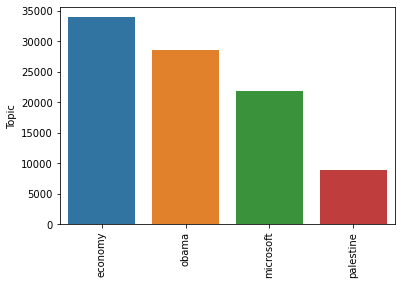

In [214]:
#checking the distribution of topics for sample vs the original dataframe
sns.barplot(df['Topic'].value_counts().index,df['Topic'].value_counts())
plt.xticks(rotation = 'vertical')

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

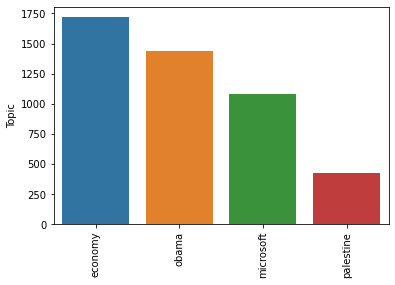

In [215]:
#checking the distribution of topics for sample vs the original dataframe
sns.barplot(df_sample['Topic'].value_counts().index,df_sample['Topic'].value_counts())
plt.xticks(rotation = 'vertical')

In [216]:
#using spacy stopwords to clean because spacy stopwords list is larger(320) when compared to the nltk(179).
#For this dataset, words which are unique will help in clustering the topic rather than regular words. 
#So using spacy could be more appropriate
#loading the spacy's english language model.
sp = spacy.load('en_core_web_sm')
spacy_stopwords = sp.Defaults.stop_words
def clean_text(text):
    words = regexp_tokenize(text.lower(),r'[a-zA-Z]+')
    words = [w for w in words if w not in spacy_stopwords and len(w)>2]
    return ' '.join(words)
    

In [217]:
#cleaning the text and appending it to a list
text_cleaned = []
for i in range(0,len(df_sample)):
    text_cleaned.append(clean_text(df_sample['Headline'][i]))
df_sample['cleaned_headline'] = text_cleaned

## Clustering using TF-IDF

In [218]:
# Vectorization

tfidf_vectorizer = TfidfVectorizer(max_features=10000, min_df=0.15, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(df_sample['cleaned_headline'].tolist() )
similarity_matrix = (tfidf_matrix * tfidf_matrix.T).A

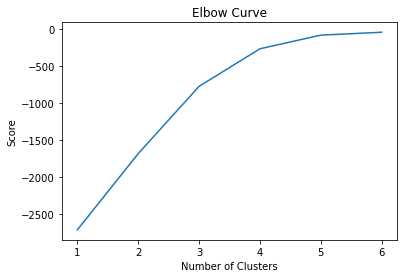

In [219]:
# Elbow Curve to find optimum "K" value
N = range(1, 7)
kmeans = [KMeans(n_clusters=i) for i in N]
score = [kmeans[i].fit(tfidf_matrix).score(tfidf_matrix) for i in range(len(kmeans))]
plt.plot(N, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [220]:
def kmeans_model(input_vector):
    #choosing 4 clusters according to the elbow curve
    num_clusters = 4
    km = KMeans(n_clusters=num_clusters)
    km.fit(input_vector)
    km_labels = km_tfidf.labels_
    km_clusters = km_tfidf_labels.tolist()
    return km_clusters
    

In [221]:
def agglomerative_model(input_vector):
    num_clusters = 4
    agglomerative_clustering = AgglomerativeClustering(n_clusters=num_clusters)
    ac_clusters = agglomerative_clustering.fit(input_vector)
    ac_labels = ac_clusters.labels_
    ac_clusters = ac_labels.tolist()
    return ac_clusters
    

In [222]:
clusters_list = kmeans_model(tfidf_matrix)
df_sample['kmeans_tfidf'] = clusters_list


In [223]:
def plot_clusters(input_vector,clusters_list):
        # Plot clusters of a subset(1500) to compute plotting faster
    tsne = TSNE(n_components=2, init='random', random_state=42, perplexity=50)
    pos = tsne.fit_transform(input_vector[:1500]) 
    xs, ys = pos[:, 0], pos[:, 1]

    # Set up cluster names using a dict
    cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4'}
    cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}

    # Plot clusters
    df_plot = pd.DataFrame(dict(x=xs, y=ys, label=clusters_list[0:1500])) 
    groups = df_plot.groupby('label')
    fig, ax = plt.subplots(figsize=(17, 9))

    for name, group in groups:
        
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
            label=cluster_names[name], color=cluster_colors[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    ax.legend(numpoints=1) 
    plt.show()
    

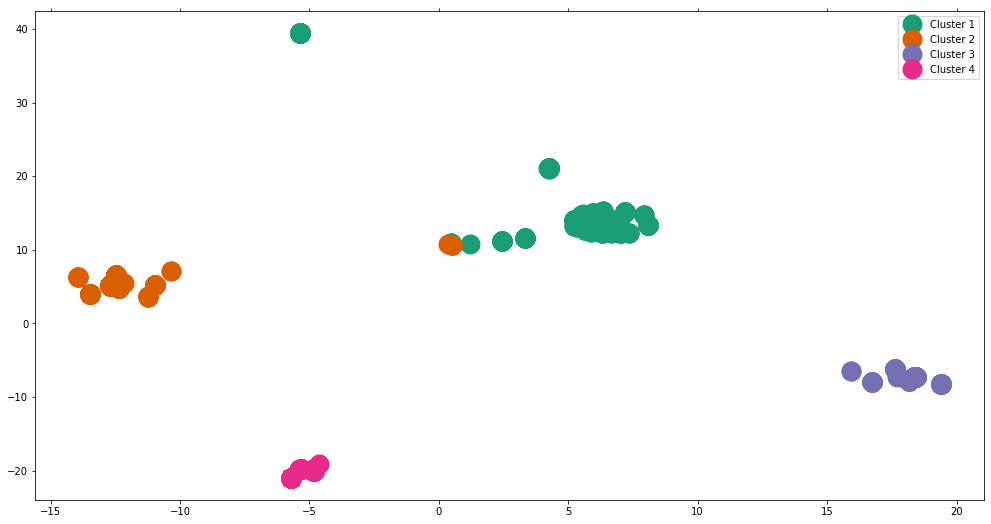

In [224]:
plot_clusters(tfidf_matrix,clusters_list)

## Agglomerative Clustering TFIDF

In [226]:
similarity_matrix = (tfidf_matrix * tfidf_matrix.T).A
cluster_list = agglomerative_model(similarity_matrix)
df_sample['agglo_tfidf'] = cluster_list

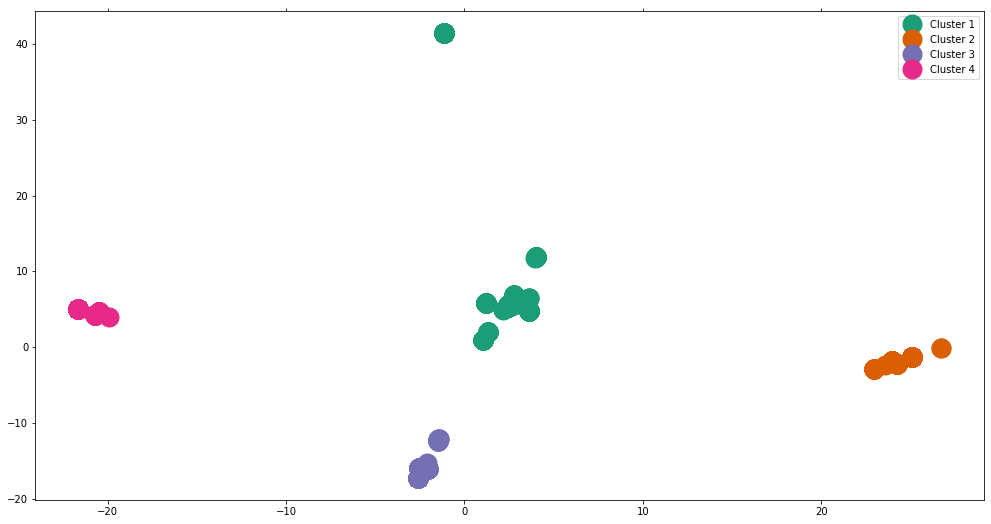

In [227]:
plot_clusters(similarity_matrix,ac_tfidf_clusters)

## Clustering using Doc2Vec

In [228]:
tokenized_list = df_sample['cleaned_headline'].to_list()

In [229]:

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_list)]
d2v_model = Doc2Vec(documents, size=20, window=8, min_count=2, workers=8)
d2v_model.train(documents, total_examples=d2v_model.corpus_count, epochs=5)

C:\Users\nagar\anaconda3\lib\site-packages\gensim\models\doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


# K means Doc2Vec

In [230]:
clusters_list = kmeans_model(doc2vector)
df_sample['kmeans_docvec'] = clusters_list

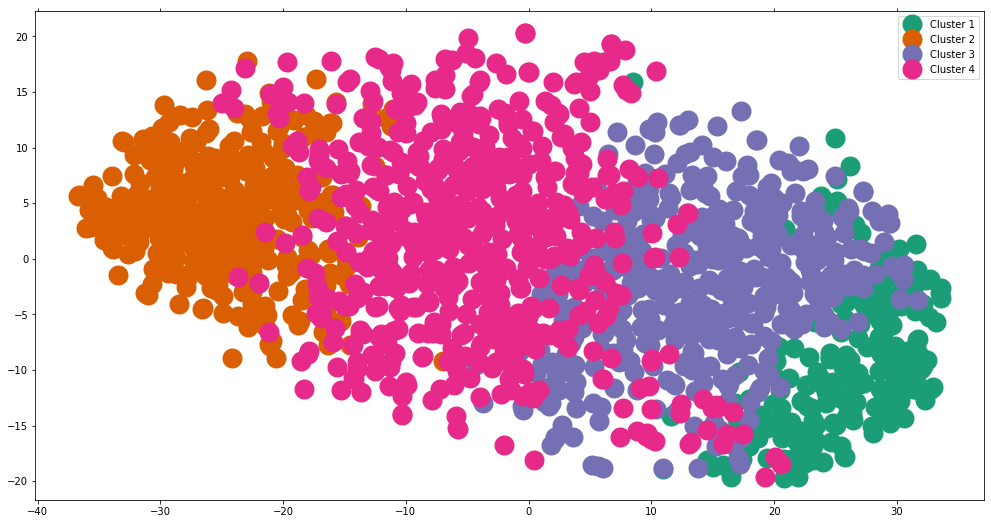

In [231]:
plot_clusters(doc2vector,km_docvec_clusters)

# using agglomerative

In [232]:
clusters_list = agglomerative_model(doc2vector)
df_sample['agglo_docvec'] = clusters_list

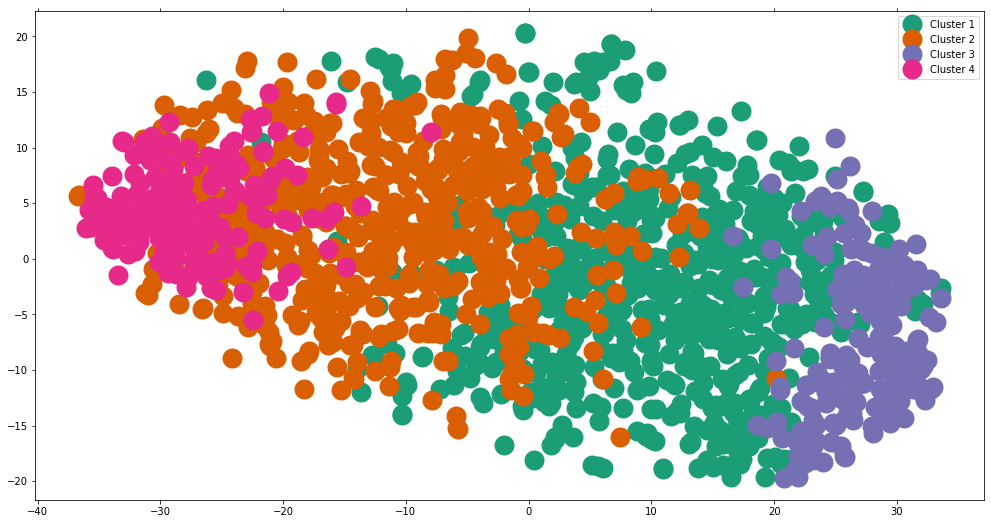

In [233]:
plot_clusters(doc2vector,ac_docvec_clusters)

# K means Word2vec

In [234]:
from gensim.models import Word2Vec
num_features = 100
tokenized_list = [simple_preprocess(h) for h in df_sample['Headline']]
train_corpus = np.array(tokenized_list)
model = Word2Vec(train_corpus, size=num_features, window=8, min_count=2, sample=1e-3, sg=1, iter=5, workers=8)
vocab = set(model.wv.index2word)

In [235]:
#tried min max for word2vec according to the stackoverflow discussion
# https://stats.stackexchange.com/questions/221715/apply-word-embeddings-to-entire-document-to-get-a-feature-vector
def minmax_word_vectors(words, model, vocabulary, num_features):
    min_vector = np.zeros((num_features,), dtype="float64")
    max_vector = np.zeros((num_features),dtype = 'float64')
    nwords = 0.
    for word in words:
        if word in vocabulary: 
            min_vector = np.minimum(min_vector, model.wv[word])
            max_vector = np.maximum(max_vector,model.wv[word])
    
    feature_vector = np.concatenate((min_vector,max_vector))
    return feature_vector

train_features = [minmax_word_vectors(sent_tokens, model, vocab, num_features) for sent_tokens in train_corpus]
minmax_train_features = np.array(train_features)

In [236]:
clusters_list = kmeans_model(minmax_train_features)
df_sample['kmeans_word2vec'] = clusters_list

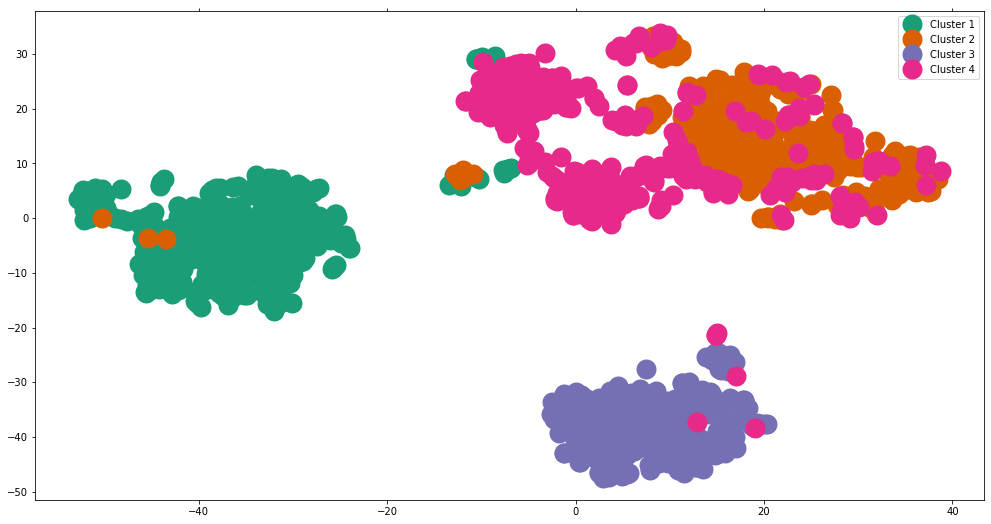

In [237]:
plot_clusters(minmax_train_features,clusters_list)

# Using Agglomerative

In [238]:
clusters_list = agglomerative_model(minmax_train_features)
df_sample['agglo_word2vec'] = clusters_list


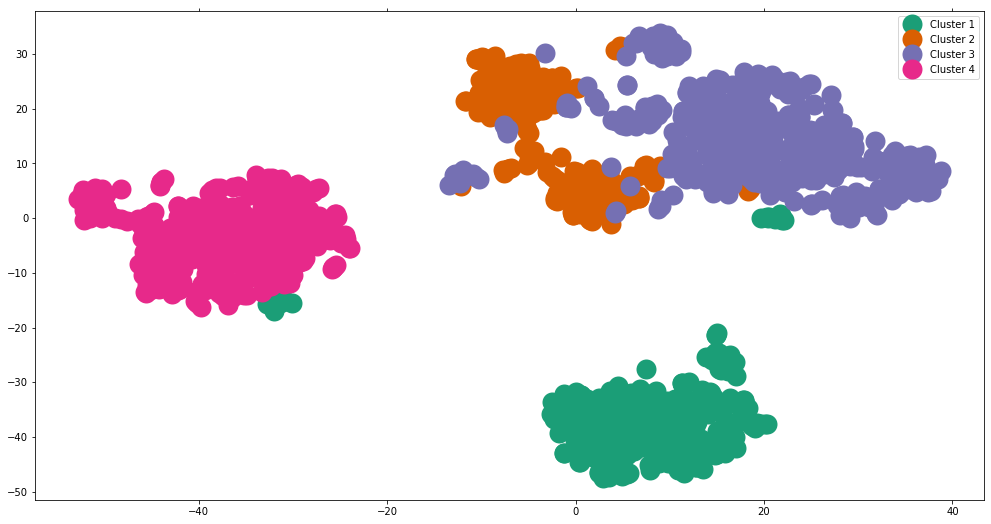

In [239]:
plot_clusters(minmax_train_features,clusters_list)

# Evaluating models

In [240]:
def plot_evaluation(x1,x2,title1,title2):  
    plt.figure(figsize=(27, 8))
# Plot of distribution of topics in clusters
    plt.subplot(131)
    sns.countplot(data=df_sample,x=x1,hue='Topic')
    plt.title(title1)

    plt.subplot(132)
    sns.countplot(data=df_sample,x=x2,hue='Topic')
    plt.title(title2)
    plt.show()

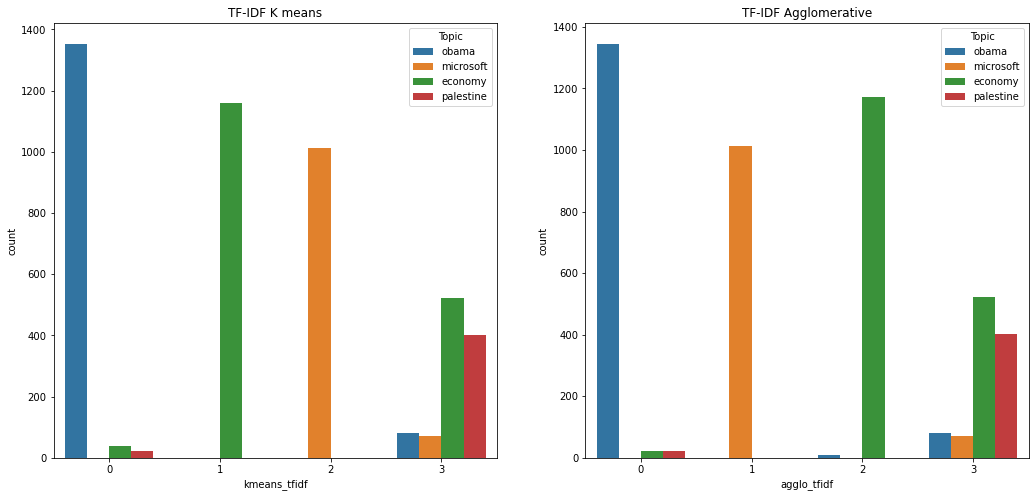

In [241]:
plot_evaluation('kmeans_tfidf','agglo_tfidf','TF-IDF K means','TF-IDF Agglomerative')

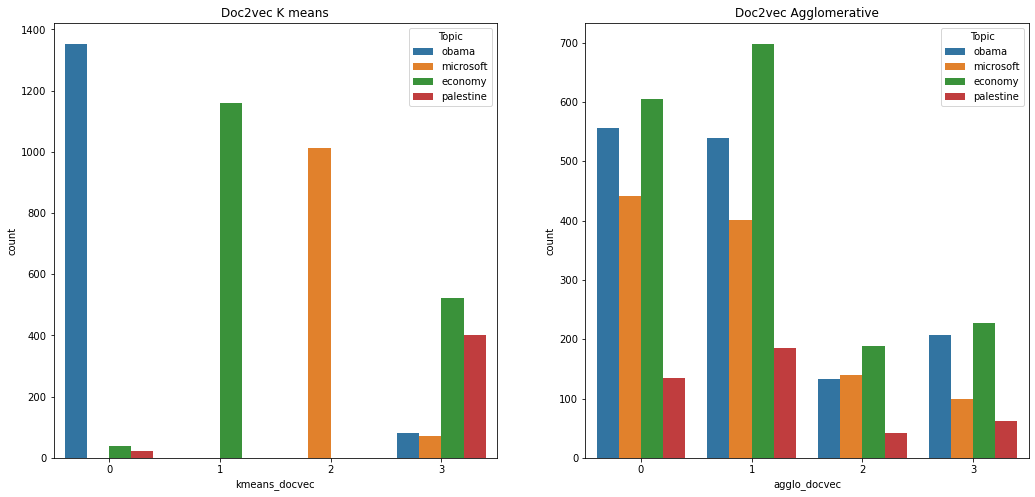

In [242]:
plot_evaluation('kmeans_docvec','agglo_docvec','Doc2vec K means','Doc2vec Agglomerative')

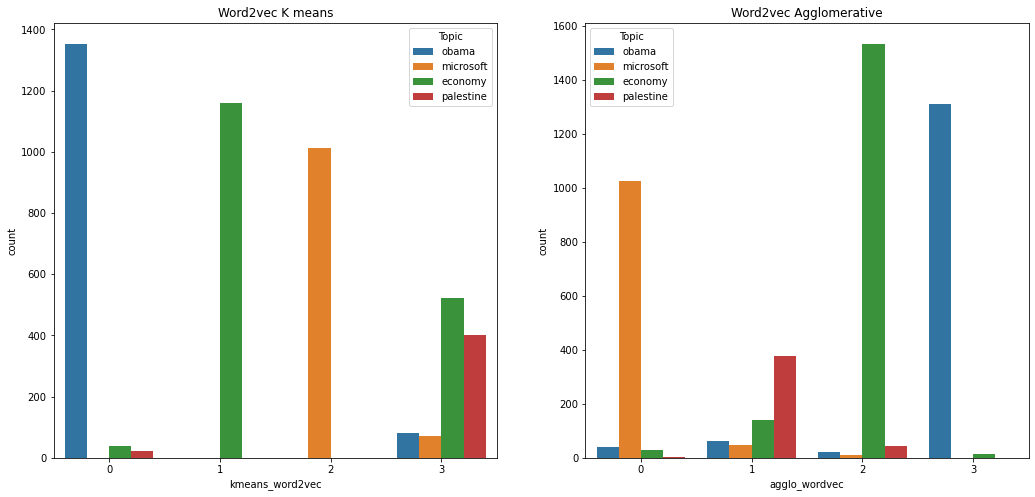

In [244]:
plot_evaluation('kmeans_word2vec','agglo_wordvec','Word2vec K means','Word2vec Agglomerative')

Conclusion:
1. TF-TDF kmeans and agglomerative performed resonably well
2. Word2vec kmeans and agglomerative has also performed well and not as good as TFIDF models
3. Doc2vec has not performed well in terms of segregating documents according to the topics known
4. Word2vec kmeans and TF-IDF k means has performed best in clustering the documents among the 6 models



In [246]:
# Exporting
df.to_csv('NagarjunaKanneganti_Assignment5.csv')